In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'LAVD3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/LAVD3D")

# Overview

In the following notebook we compute the Lagrangian Averaged Vorticity Deviation ($ \mathrm{LAVD} $) on the three-dimensional, steady ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'ABCsteady.mat' stored in the folder 'data/ABC'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{LAVD} $:

    * Compute vorticity $ \mathbf{\omega}(\mathbf{F}_{t_0}^{t}(\mathbf{x}_0),t) $ along particle trajectories. The ABC-flow satisfies the strong Beltrami property. It thus holds:
    \begin{equation}
    \mathbf{\omega}(\mathbf{F}_{t_0}^{t}(\mathbf{x}_0),t) = \mathbf{v}(\mathbf{F}_{t_0}^{t}(\mathbf{x}_0),t)= \dfrac{d}{dt}\mathbf{F}_{t_0}^{t}(\mathbf{x}_0)
    \end{equation}
    
    Although due to the strong Beltrami property the vorticity can directly be inferred from the velocity, one cannot assume that for arbitry type of flows. We hence computed the vorticity along particle trajectories according to:
    
    \begin{equation}
    \mathbf{\omega}(\mathbf{x},t) = \nabla \times \mathbf{v}(\mathbf{x}, t)
    \end{equation}
    <br />
    
    * Compute $ \mathrm{LAVD} $:
    \begin{equation}
    \mathrm{LAVD}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N}| \omega(\mathbf{F}_{t_0}^{t}(\mathbf{x}_0)) - \overline{\omega}(t) |dt,
    \end{equation} where $ \overline{\omega}(t_i) $ denotes the spatio-temporal average over the defined domain.
    <br />
    For the ABC-flow it holds: $ \overline{\omega}(t_i) = 0, \ \forall i \in \lbrace 0, ..., N \rbrace $.
  
 <br />
6. References

# Import data

We start by importing the ABC-data from 'ABCunsteady.mat' located in the folder 'data/ABC'.

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = False # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# auxiliary grid spacing
aux_grid = [0.1*delta[0], 0.1*delta[1], 0.1*delta[2]] # list (3,)

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 50 # float

# Time step-size
dt = 0.1 # float

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 150 # int
Nx = 150 # int
Nz = 150 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [5]:
# Import interpolation function for steady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# LAVD

The computation of the $ \mathrm{LAVD} $ is not done over the 3D meshgrid but only over the 2D faces of the cube $ [0,2\pi]^3 $.
We iterate over all initial conditions on the faces of the cube and calculate the vorticity along the particle trajectories. In the ABC-flow, the vorticity coincides with the velocity. Furthermore, from the periodicity of the velocity field it can also be inferred that the spatially averaged velocity/vorticity is identically zero. 
From the velocity/vorticity along the particle trajectories we then compute the $ \mathrm{LAVD} $.

In [6]:
# Import function to compute flow map (=trajectories) and derivative of flow map (=velocity along trajectories)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute Lagrangian Averaged Vorticity Deviation (LAVD)
from ipynb.fs.defs.LAVD import _LAVD

# Import function to compute Lagrangian Averaged Vorticity Deviation (LAVD)
from ipynb.fs.defs.vorticity import vorticity

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_omega(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    Fmap = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady)[0] # array (Nt, 3, Nx*Ny*Nz)
    
    # As the ABC-flow satisfies the strong Beltrami property, the vorticity coincides with the velocity.
    omega = np.zeros(Fmap.shape)
    
    for i in range(Fmap.shape[0]):
        omega[i,:,:] = vorticity(time[i], Fmap[i,:,:], X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid)
    
    return omega

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

## XY-plane

Compute $ \mathrm{LAVD} $ on XY-plane.

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
z0_xy = Z_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_omega)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
omega_xy = results[0]
for res in results[1:]:
    omega_xy = np.append(omega_xy, res, axis = -1)
    

omega_avg = np.zeros((omega_xy.shape[0], 3))
LAVD_xy = _LAVD(omega_xy, time, omega_avg)

X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
LAVD_xy = np.array(LAVD_xy).reshape(Ny,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  1.2min remaining:  3.0min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.2min finished


  0%|          | 0/499 [00:00<?, ?it/s]

## XZ-plane

Compute $ \mathrm{LAVD} $ on XZ-plane.

In [ ]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )
y0_xz = Y_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Ny*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_omega)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
omega_xz = results[0]
for res in results[1:]:
    omega_xz = np.append(omega_xz, res, axis = -1)
    
omega_avg = np.zeros((omega_xz.shape[0], 3))
LAVD_xz = _LAVD(omega_xz, time, omega_avg)

X0_xz = np.array(x0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Nz, Nx)
LAVD_xz = np.array(LAVD_xz).reshape(Nz,Nx) # array (Nz, Nx)

## YZ-plane

Compute $ \mathrm{LAVD} $ on YZ-plane.

In [10]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_yz = X_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
y0_yz = Y_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
z0_yz = Z_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_omega)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
omega_yz = results[0]
for res in results[1:]:
    omega_yz = np.append(omega_yz, res, axis = -1)
    
omega_avg = np.zeros((omega_yz.shape[0], 3))
LAVD_yz = _LAVD(omega_yz, time, omega_avg)

X0_yz = np.array(x0_yz).reshape(Nz,Ny) # array (Nz, Ny)
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nz, Ny)
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nz, Ny)
LAVD_yz = np.array(LAVD_yz).reshape(Nz,Ny) # array (Nz, Ny)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  1.2min remaining:  3.0min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.2min finished


  0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
############################################ PLOT RESULTS ############################################

# Import plotly for 3D figures
from plotly import graph_objs as go 

# define minimum and maximum values for colorbar
min_value = min(np.min(LAVD_yz),min(np.min(LAVD_xy), np.min(LAVD_xz)))
max_value = max(np.max(LAVD_yz),max(np.max(LAVD_xy), np.max(LAVD_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = LAVD_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = LAVD_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = LAVD_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = LAVD_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = LAVD_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = LAVD_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{LAVD}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

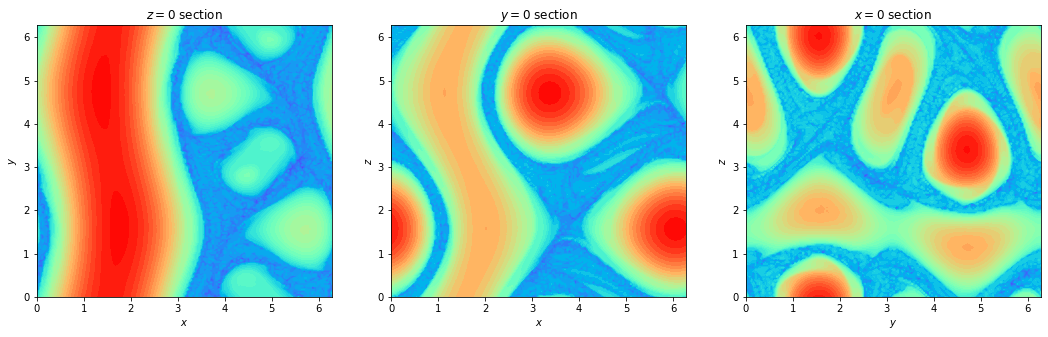

In [11]:
import matplotlib.pyplot as plt
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, LAVD_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, LAVD_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, LAVD_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

Elliptic LCS are visible as convex tubular surfaces with a sharp drop in the $ \mathrm{LAVD} $-field. The structures highlighted by the $ \mathrm{LAVD} $-field can directly be compared to those of the [$ \mathrm{\overline{TRA}}$](../../TRA3D/Main/TRAABCsteady.ipynb)-field. In general, the structures generated by the $ \mathrm{LAVD} $ are not robust under subsampling as the computation of the vorticity along a particle trajectory requires evaluating spatial derivatives of the velocity-field. Strong Beltrami flows are an exception as the vorticity is equivalent to the velocity and hence no spatial derivatives are required in this special flow.

# References

[1] Haller, G., Hadjighasem, A., Farazmand, M., & Huhn, F. (2016). Defining coherent vortices objectively from the vorticity. Journal of Fluid Mechanics, 795, 136-173.

[2] Notebook 5.2.7. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.